## 0.1) imports

### 0.1.1) modules

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

import os
import json
from pathlib import Path

from tensorflow.keras import models, layers, optimizers, Model
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf


from power.params import *
from power.utils import plot_loss_mae
from power.interface.main import evaluate
from power.ml_ops.registry import save_model, save_results, load_model


### 0.1.2) data

In [43]:
#### Load saved sequences
sequence_cache_path = Path(LOCAL_DATA_PATH).joinpath("sequences")
X = np.load(sequence_cache_path.joinpath('X_train.npy'))
y = np.load(sequence_cache_path.joinpath('y_train.npy'))

X_full = np.load(sequence_cache_path.joinpath('X_train_full.npy'))
y_full = np.load(sequence_cache_path.joinpath('y_train_full.npy'))

## Get all data
data_processed_pv_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed_pv = pd.read_csv(data_processed_pv_cache_path)

data_processed_forecast_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
data_processed_forecast = pd.read_csv(data_processed_forecast_cache_path)

data_processed_pv.utc_time = pd.to_datetime(data_processed_pv.utc_time,utc=True)

### Initialize Dictionnaries
val_performance = {}
performance = {}
history = {}

## 0.2) functions

### 0.2.1) train_model

In [44]:
def train_model(model,
                X_train,
                y_train,
                validation_split = 0.3,
                batch_size = 32,
                epochs = 100):

    es = EarlyStopping(monitor = "val_mae",
                       mode = "min",
                       patience = 10,
                       restore_best_weights = True)

    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        shuffle=False,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = [es],
                        verbose = 0)
    return model, history


### 0.2.2) tune PV data

In [45]:
# X_train, y_train = X, y
LEARNING_RATE = 1e-3
train_start_pv: str = '1980-01-01 00:00:00'
train_stop_pv: str = '2014-05-26 18:00:00'
train_start_forecast: str = '2017-10-07 00:00:00'
train_stop_forecast: str = '2021-12-13 18:00:00'

adam = optimizers.Adam(learning_rate=LEARNING_RATE)
RMSprop = optimizers.RMSprop(learning_rate= LEARNING_RATE)

output_length = y.shape[1]

def tune_model_pv(model,
                  model_name,
                  X_train=X,
                  y_train=y,
                  optimizer= adam):


    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    print(model.summary())

    model, history = train_model(model, X_train, y_train)
    val_mae = np.min(history.history['val_mae'])

    params = dict(
        context="train",
        training_set_size=f'Training data from {train_start_pv} to {train_stop_pv}',
        row_count=len(X_train),
    )

    # Save results on the hard drive using power.ml_logic.registry
    save_results(params=params, metrics=dict(mae=val_mae), history=history)

    # Save model weight on the hard drive (and optionally on GCS too!)
    save_model(model=model, forecast_features=False)
    plot_loss_mae(history)
    performance_mae = evaluate(forecast_features= False)

    # Store in 2 JSON Files
    with open("val_performance.json", "r") as jsonFile:
        val_performance = json.load(jsonFile)
    with open("performance.json", "r") as jsonFile:
        performance = json.load(jsonFile)

    val_performance[model_name] = val_mae
    performance[model_name] = performance_mae

    with open("val_performance.json", "w") as jsonFile:
        json.dump(val_performance, jsonFile)
    with open("performance.json", "w") as jsonFile:
        json.dump(performance, jsonFile)

### 0.2.2) tune PV + Forecast data

In [46]:
LEARNING_RATE = 1e-3
train_start_pv: str = '1980-01-01 00:00:00'
train_stop_pv: str = '2014-05-26 18:00:00'
train_start_forecast: str = '2017-10-07 00:00:00'
train_stop_forecast: str = '2021-12-13 18:00:00'

adam = optimizers.Adam(learning_rate=LEARNING_RATE)
RMSprop = optimizers.RMSprop(learning_rate= LEARNING_RATE)

output_length = y_full.shape[1]

def tune_model_forecast(model,
                  model_name,
                  X_train=X_full,
                  y_train=y_full,
                  optimizer= adam):


    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    print(model.summary())

    model, history = train_model(model, X_train, y_train)
    val_mae = np.min(history.history['val_mae'])

    params = dict(
        context="train",
        training_set_size=f'Training data from {train_start_pv} to {train_stop_pv}',
        row_count=len(X_train),
    )

    # Save results on the hard drive using power.ml_logic.registry
    save_results(params=params, metrics=dict(mae=val_mae), history=history)

    # Save model weight on the hard drive (and optionally on GCS too!)
    save_model(model=model, forecast_features=True)
    plot_loss_mae(history)
    performance_mae = evaluate(forecast_features= True)

    # Store in 2 JSON Files
    with open("val_performance.json", "r") as jsonFile:
        val_performance = json.load(jsonFile)
    with open("performance.json", "r") as jsonFile:
        performance = json.load(jsonFile)

    val_performance[model_name] = val_mae
    performance[model_name] = performance_mae

    with open("val_performance.json", "w") as jsonFile:
        json.dump(val_performance, jsonFile)
    with open("performance.json", "w") as jsonFile:
        json.dump(performance, jsonFile)

In [47]:
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

In [140]:
performance_df = pd.DataFrame({'model': performance.keys(),
                               'performance': performance.values()})
val_performance_df = pd.DataFrame({'model': val_performance.keys(),
                               'val_performance': val_performance.values()})

full_performance_df = performance_df.merge(val_performance_df, on='model', how='left')
_ = full_performance_df.sort_values(by='val_performance')

column_indices = {name: i for i, name in enumerate(full_performance_df)}
arr = _.to_numpy()
models = arr[:,0]
perf = arr[:,1]
val_perf = arr[:,2]
perf, val_perf
_

,model,performance,val_performance
13,SimpleRNN Full,0.041297,0.033285
5,LSTM_lr-1e-3,0.053646,0.053779
6,LSTM_lr-1e-3_RMSprop,0.052997,0.054801
4,LSTM_lr-1e-2,0.056245,0.057021
9,X_full_LSTM_lr-1e-3_adam_3-layers_1-DO_normali...,0.068679,0.062946
0,baseline,0.000000,0.063165
8,X_full_LSTM_lr-1e-3_adam_3-layers_1-DO,0.070430,0.064163
2,LSTM_lr-1e-1,0.064239,0.065651
12,Input-Norm-2-LSTM_2-Dense_DO_2-Dense-Output,0.076080,0.076241
10,Input - Norm - 2-LSTM - D - DO,0.074154,0.076338


In [60]:
df = full_performance_df.sort_values(by='val_performance').copy()


for name, value in df.iterrows():
    print(value[2])

0.03328496962785721
0.05377902090549469
0.05480068922042847
0.05702060088515282
0.06294584274291992
0.06316520273685455
0.06416290998458862
0.06565100699663162
0.0762406587600708
0.07633840292692184
0.07656538486480713
0.0771205946803093
0.07810379564762115
0.09817010164260864


/tmp/ipykernel_12113/2592313987.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(value[2])


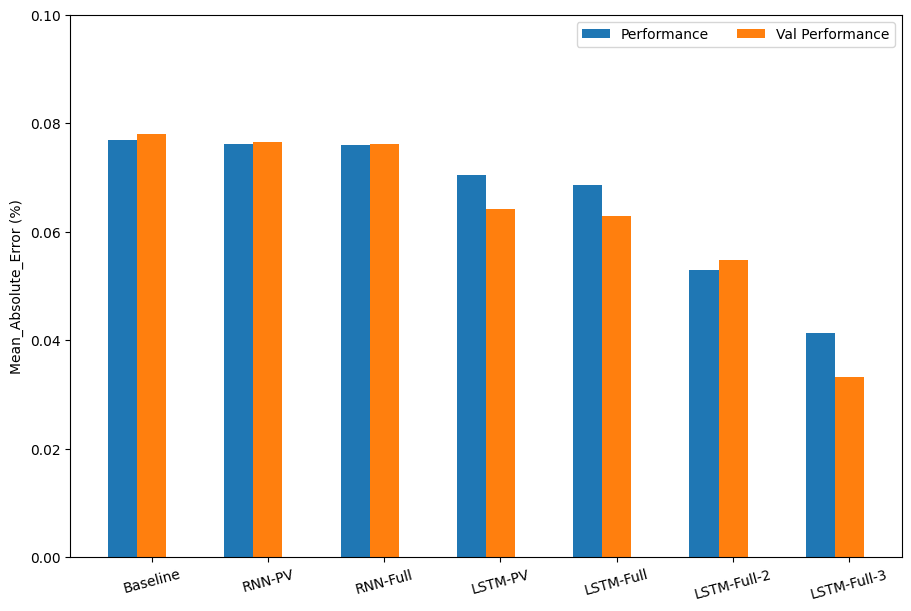

array([0.0781038 , 0.07656538, 0.07624066, 0.06416291, 0.06294584,
       0.05480069, 0.03328497])

In [139]:
# data from https://allisonhorst.github.io/palmerpenguins/

# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

_ = full_performance_df.sort_values(by='val_performance', ascending= False)
species = _.model.values[1::2]
species = ['Baseline', 'RNN-PV', 'RNN-Full', 'LSTM-PV', 'LSTM-Full', 'LSTM-Full-2', 'LSTM-Full-3']
penguin_means = {
    'Performance': _.performance.values[1::2],
    'Val Performance': _.val_performance.values[1::2],
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9,6))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean_Absolute_Error (%)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species, rotation=15)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 0.100)

plt.show()
_.val_performance.values[1::2]


# 1) Baseline

In [20]:
from power.ml_ops.data import get_data_with_cache
from power.ml_ops.cross_val import get_X_y_seq_pv, get_X_y_seq
from power.ml_ops.model import evaluate_model

from colorama import Fore, Style

def evaluate_baseline(
        model,
        min_date: str = '2019-12-31 23:00:00',
        forecast_features: bool = False,
        stage: str = "Production"
    ) -> float:
    """
    Evaluate the performance of the latest production model on processed data
    Return MAE as a float
    """
    print(Fore.MAGENTA + "\n⭐️ Use case: evaluate baseline" + Style.RESET_ALL)



    # Query your BigQuery processed table and get data_processed using `get_data_with_cache`
    query = f"""
        SELECT *
        FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
        ORDER BY utc_time
    """

    data_processed_pv_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_processed_pv = get_data_with_cache(
        gcp_project=GCP_PROJECT,
        query=query,
        cache_path=data_processed_pv_cache_path,
        data_has_header=True
    )

    # the processed PV data from bq needs to be converted to datetime object
    data_processed_pv.utc_time = pd.to_datetime(data_processed_pv.utc_time,utc=True)

    if data_processed_pv.shape[0] == 0:
        print("❌ No data to evaluate on")
        return None

    if forecast_features:
    # --Second-- Load processed Weather Forecast data in chronological order
        query_forecast = f"""
            SELECT *
            FROM {GCP_PROJECT}.{BQ_DATASET}.processed_weather_forecast
            ORDER BY forecast_dt_unixtime, slice_dt_unixtime
        """

        data_processed_forecast_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
        data_processed_forecast = get_data_with_cache(
            gcp_project=GCP_PROJECT,
            query=query_forecast,
            cache_path=data_processed_forecast_cache_path,
            data_has_header=True
        )

        if data_processed_forecast.shape[0] < 240:
            print("❌ Not enough processed data retrieved to train on")
            return None

        # Split the data into training and testing sets
        test_pv = data_processed_pv[data_processed_pv['utc_time'] > min_date]
        test_forecast = data_processed_forecast

        X_test, y_test = get_X_y_seq(test_pv,
                                    test_forecast,
                                    number_of_sequences=1_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)
        # model = load_model(forecast_features= True, stage=stage)
        # assert model is not None

        metrics_dict = evaluate_model(model=model, X=X_test, y=y_test)
        mae = metrics_dict["mae"]

    else:
        # Split the data into training and testing sets
        test_pv = data_processed_pv[data_processed_pv['utc_time'] > min_date]

        X_test, y_test = get_X_y_seq_pv(test_pv,
                                    number_of_sequences=1_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)

        metrics_dict = evaluate_model(model=model, X=X_test, y=y_test)
        mae = metrics_dict["mae"]

    params = dict(
        context="evaluate", # Package behavior
        evaluate_set_size="3 years",
    )

    save_results(params=params, metrics=metrics_dict)

    print("✅ evaluate() done \n")

    return mae, X_test, y_test, metrics_dict

In [21]:
X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

class Baseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    result = result[:, :, tf.newaxis]
    result = result[:, 12:-12, :]
    return result

baseline = Baseline(label_index=0)

adam = optimizers.Adam(learning_rate=LEARNING_RATE)
baseline.compile(loss='mse', optimizer=adam, metrics=['mae'])

mae, X_test, y_test, metrics_dict = evaluate_baseline(baseline)

# val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['baseline'] = metrics_dict['mae']
performance['baseline'] = 0.00

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)


⭐️ Use case: evaluate baseline

Load data from local CSV...
✅ Data loaded, with shape (376944, 6)


100%|██████████| 1000/1000 [00:01<00:00, 520.68it/s]


✅ Model evaluated, MAE: 0.06
✅ Results saved locally
✅ evaluate() done 



In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

column_indices = {name:i for i,name in enumerate(data_processed_pv)}

def plot(model=None, X_test=X_test, y_test=y_test, column_indices= column_indices, plot_col='electricity', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('electricity')


Text(0.35, 0.84, 'Baseline Predicitions Interval')

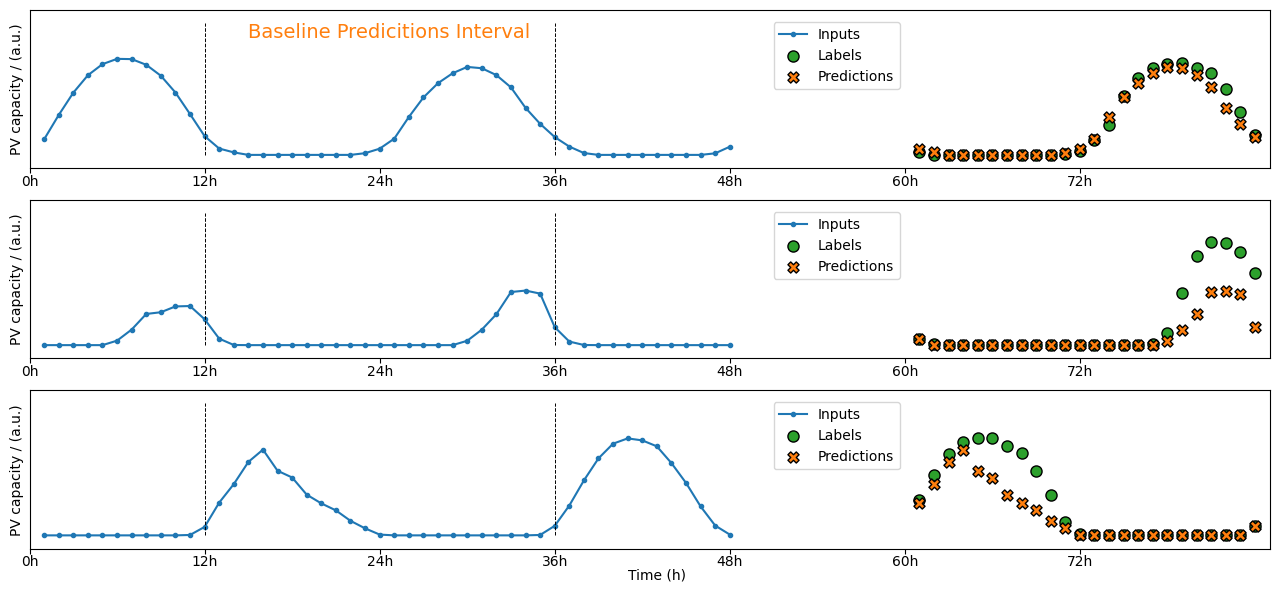

In [63]:
###### Input and labels #####################
##########################################
input_width = 48
label_width = 24
offset = 36

total_window_size = input_width + offset

input_slice = slice(0, input_width)
input_indices = np.arange(total_window_size)[input_slice]

label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
label_indices = np.arange(total_window_size)[labels_slice]

label_columns = ['electricity']
label_columns_indices = {name: i for i, name in enumerate(label_columns)}


#####  Sequences ###########
######################################
max_n = 3
seq_number = np.random.randint(0, 1000, max_n)

### Plot #######################
########################################
fig, axs = plt.subplots(nrows= max_n, ncols= 1, figsize=(16,7), sharex= True, sharey= True)

for n, ax in enumerate(axs):

    ax.plot(input_indices,X_test[seq_number[n],:,0], label='Inputs', marker='.')#, zorder=-10, c='b')
    ax.scatter(label_indices, y_test[seq_number[n],:,0], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    ax.scatter(label_indices, X_test[seq_number[n],12:-12,0], marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

    ax.vlines(11, ymin=0, ymax=1, color='k', linewidth=0.7, linestyle='--')
    ax.vlines(35, ymin=0, ymax=1, color='k', linewidth=0.7, linestyle='--')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-1,84)

    # ax.set_axis_off()
    ax.set_yticks([])
    ax.set_ylabel('PV capacity / (a.u.)')

    x_labels = np.arange(total_window_size, step=12)
    ax.set_xticks([i - 1 for i in x_labels])
    ax.set_xticklabels([])

    for value in x_labels:
        ax.text(x= value-1, y=-0.2, s= f"{value}h", va='center', ha='center')

    ax.legend(loc=(0.6, 0.5))

plt.text(x= 42, y=-0.3, s= f"Time (h)", va='center', ha='center')

text = 'Baseline Predicitions Interval'
fig.text(
    0.35, 0.84,
    text,
    ha='center',
    fontsize=14,
    c='#ff7f0e'
    )


# 2) PV models

## Model-1: RNN

The most simple model to be used is a simple RNN model. We simply start the Sequential architecture with an input Layer folllowed by a normalization layer, which will come in handy once we feed features from the weather forecast.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24)                720       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
None
✅ Results saved locally
✅ Model saved locally


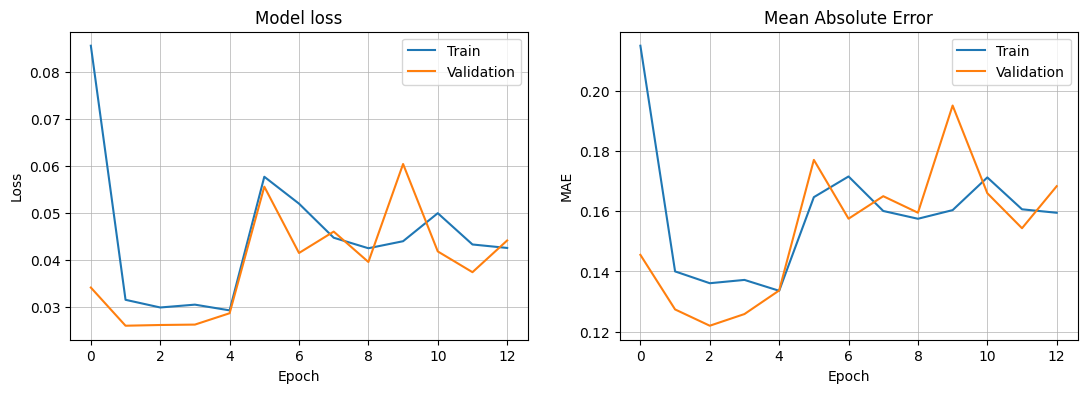


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 6)

Load data from local CSV...
✅ Data loaded, with shape (91704, 24)


  0%|          | 0/1000 [00:00<?, ?it/s]/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['utc_time'] = pd.to_datetime(forecast['utc_time'])
/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['prediction_utc_time'] = pd.to_datetime(forecast['prediction_utc_time']


Load latest model from local registry...

Load latest model from disk...


2024-11-21 17:45:44.701007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-21 17:45:44.703320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-21 17:45:44.707115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-21 17:45:45.228292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-21 17:45:45.231162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-21 17:45:45.233205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.04
✅ Results saved locally
✅ evaluate() done 



In [50]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    # layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.SimpleRNN(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
performance_mae = evaluate()

# Store in 2 JSON Files
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['SimpleRNN'] = val_mae
performance['SimpleRNN'] = performance_mae

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)

In [ ]:
# with open("val_performance.json", "r") as jsonFile:
#     data = json.load(jsonFile)

# data["location"] = val_performance

with open("replayScript.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)


In [ ]:
with open("replayScript.json", "r") as jsonFile:
    data = json.load(jsonFile)

data

## Model-2: LSTM

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
performance_mae = evaluate()

# Store in 2 JSON Files
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['LSTM_lr-1e-1'] = val_mae
performance['LSTM_lr-1e-1'] = performance_mae

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)

## Model-3: GRU

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.GRU(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
performance_mae = evaluate()

# Store in 2 JSON Files
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['GRU_lr-1e-1'] = val_mae
performance['GRU_lr-1e-1'] = performance_mae

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)

## Model-4 LSTM: learning rate 1e-2

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-2
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)


performance_mae = evaluate()

# Store in 2 JSON Files
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['LSTM_lr-1e-2'] = val_mae
performance['LSTM_lr-1e-2'] = performance_mae

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)

## Model-5: LSTM: learning rate 1e-3

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-3
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])


adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
performance_mae = evaluate()

# Store in 2 JSON Files
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['LSTM_lr-1e-3'] = val_mae
performance['LSTM_lr-1e-3'] = performance_mae

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)

## Model-6 | LSTM - LR: 1e-4

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-4
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## Model-7 | LSTM - LR 1e-3 - RMSprop

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-3
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
RMSprop = optimizers.RMSprop(learning_rate= LEARNING_RATE)
model.compile(loss='mse', optimizer=RMSprop, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
performance_mae = evaluate()

# Store in 2 JSON Files
with open("val_performance.json", "r") as jsonFile:
    val_performance = json.load(jsonFile)
with open("performance.json", "r") as jsonFile:
    performance = json.load(jsonFile)

val_performance['LSTM_lr-1e-3_RMSprop'] = val_mae
performance['LSTM_lr-1e-3_RMSprop'] = performance_mae

with open("val_performance.json", "w") as jsonFile:
    json.dump(val_performance, jsonFile)
with open("performance.json", "w") as jsonFile:
    json.dump(performance, jsonFile)

## Model-8 | Input - Norm - 2-LSTM - D - DO

2024-11-20 15:56:29.175280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 15:56:29.177686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 15:56:29.179544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 48, 5)            11        
 ion)                                                            
                                                                 
 lstm (LSTM)                 (None, 48, 24)            2880      
                                                                 
 lstm_1 (LSTM)               (None, 24)                4704      
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                408       
                                                        

2024-11-20 15:56:29.605246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 15:56:29.608159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 15:56:29.610344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-20 15:56:30.708705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 15:56:30.714735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 15:56:30.718056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


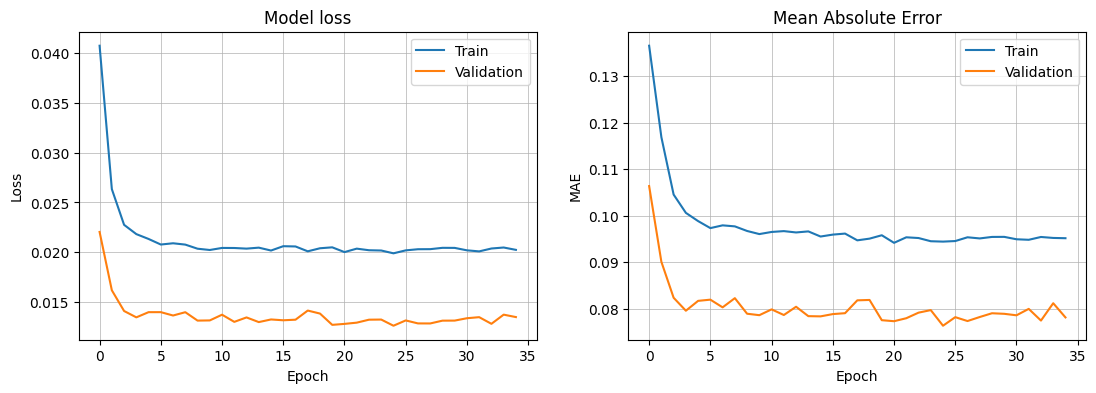


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 6)


100%|██████████| 1000/1000 [00:01<00:00, 906.04it/s]



Load latest model from local registry...

Load latest model from disk...


2024-11-20 16:02:41.212862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:02:41.217481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:02:41.221347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-20 16:02:42.725857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:02:42.728804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:02:42.732800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.07
✅ Results saved locally
✅ evaluate() done 



In [8]:
X_train = X
# 1 - RNN architecture
    # ======================

############### Normalization Layer ####################################
normalizer = layers.Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

model_8 = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    normalizer,
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = True),
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    layers.Dense(units=16, activation='relu'),
    layers.Dropout(0.5),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])

tune_model_pv(model_8, 'Input - Norm - 2-LSTM - D - DO', X, y)

## Model-9 | Input-Norm-LSTM_2-Dense_DO_2-Dense-Output

In [14]:
X_train = X
# 1 - RNN architecture
    # ======================

############### Normalization Layer ####################################
normalizer = layers.Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

model_9 = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    normalizer,
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])

tune_model_pv(model_9, 'Input-Norm-LSTM_2-Dense_DO_2-Dense-Output', X, y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 48, 5)            11        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 24)                2880      
                                                                 
 dense_5 (Dense)             (None, 16)                400       
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                      

2024-11-20 16:41:26.220983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:41:26.225300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:41:26.228661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-20 16:41:27.027505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:41:27.031956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:41:27.034705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyError: in user code:

    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1247, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/home/jerome-roeser/.cache/pypoetry/virtualenvs/power-Shvux39R-py3.10/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 232, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable lstm_2/lstm_cell_4/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


## Model-10 | Input-Norm-2-LSTM_2-Dense_DO_2-Dense-Output

2024-11-20 16:35:33.558650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:35:33.561341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:35:33.564696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 48, 5)            11        
 ion)                                                            
                                                                 
 lstm (LSTM)                 (None, 48, 24)            2880      
                                                                 
 lstm_1 (LSTM)               (None, 24)                4704      
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                        

2024-11-20 16:35:34.951736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:35:34.954688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:35:34.957094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


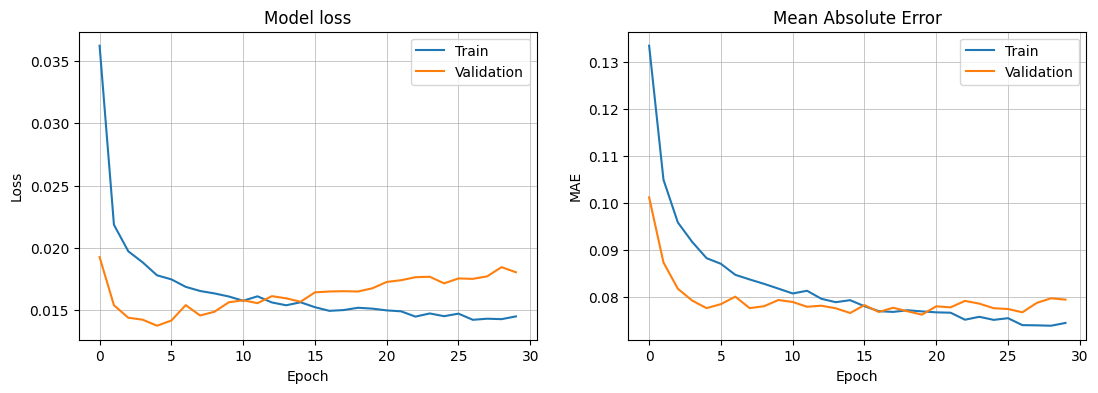


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 6)


100%|██████████| 1000/1000 [00:01<00:00, 768.94it/s]



Load latest model from local registry...

Load latest model from disk...


2024-11-20 16:41:08.880321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:41:08.883621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:41:08.886870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-20 16:41:10.052340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 16:41:10.055162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 16:41:10.057195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.08
✅ Results saved locally
✅ evaluate() done 



In [13]:
X_train = X
# 1 - RNN architecture
    # ======================

############### Normalization Layer ####################################
normalizer = layers.Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

model_10 = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    normalizer,
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = True),
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])

tune_model_pv(model_10, 'Input-Norm-2-LSTM_2-Dense_DO_2-Dense-Output', X, y)

# 3) PV + Forecast Model

## Model-1 | Input - Norm - 2-LSTM - D - DO

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, X_full
LEARNING_RATE = 1e-3
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

normalizer = layers.Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

model_14 = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    normalizer,
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = True),
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    layers.Dense(units=16, activation='relu'),
    layers.Dropout(0.5),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])


tune_model_forecast(model_14, 'X_full_LSTM_lr-1e-3_adam_3-layers_1-DO_normalization_before_input', X_full, y_full)

## Model-102 | SimpleRNN Full

2024-11-21 17:30:56.758781: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51840000 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 27)           55        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 24)                4992      
                                                                 
 dense (Dense)               (None, 24)                600       
                                                                 
Total params: 5,647
Trainable params: 5,592
Non-trainable params: 55
_________________________________________________________________


2024-11-21 17:30:58.350381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-21 17:30:58.354667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-21 17:30:58.357014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-21 17:30:59.116691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-21 17:30:59.121688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-21 17:30:59.125026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


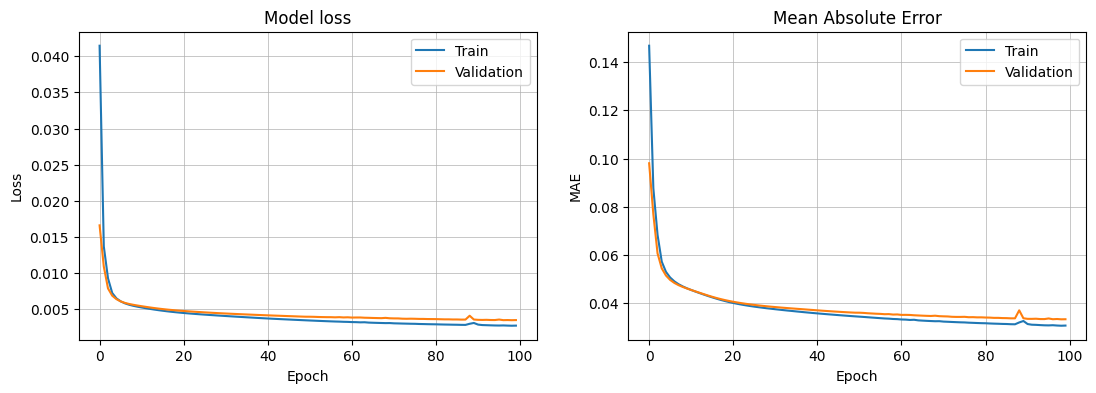


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 6)

Load data from local CSV...
✅ Data loaded, with shape (91704, 24)


  0%|          | 0/1000 [00:00<?, ?it/s]/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['utc_time'] = pd.to_datetime(forecast['utc_time'])
/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['prediction_utc_time'] = pd.to_datetime(forecast['prediction_utc_time']


Load latest model from local registry...

Load latest model from disk...


2024-11-21 17:39:59.812607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-21 17:39:59.816724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-21 17:39:59.819871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-21 17:40:00.514660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-21 17:40:00.517184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-21 17:40:00.519227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.04
✅ Results saved locally
✅ evaluate() done 



In [38]:
X_train = X_full
# 1 - RNN architecture
    # ======================

############### Normalization Layer ####################################
normalizer = layers.Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

model_104 = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    normalizer,
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])

tune_model_forecast(model_104, 'SimpleRNN Full', X_full, y_full)